# Annotation of artifacts

## Introduction

We will show here how artifacts can be identified and then annotated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.  

## Preparation

Import the relevant modules: 

In [1]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import annotate_muscle_zscore

Set the path and load the FIF-files: 

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
max_suffix = 'raw_sss'
ann_suffix = 'ann'
ica_suffix = 'ica'

#deriv_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing'
deriv_root = r'/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=max_suffix, 
            root=deriv_root, extension='.fif', check=False)
print(bids_path.fpath)


# The annotations will be stored in these files
ann_fname = bids_path.basename.replace(max_suffix, ann_suffix) # output filename
ann_fname = ann_fname.replace('fif', 'csv') # output filename

ann_fname_1 = op.join(bids_path.directory, ann_fname)
ann_fname_2 = ann_fname_1.replace('run-01', 'run-02')

                                   

/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif


In [3]:
data1 = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file /Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif...
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...


/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/3807992030.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  data1 = read_raw_bids(bids_path=bids_path,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/3807992030.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  data1 = read_raw_bids(bids_path=bids_path,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/3807992030.py:1: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*me

## Identifying eye blinks

Here we show how the artifacts associated with eye blinks can be marked automatically on the basis of the vertical EOG channel (EOG001 in our case). After bandpass filtering the EOG signal between 1 - 10 Hz, the threshold for blink detection is determined according to:

$$ (max(vEOG) - min(vEOG)) / 4 $$

 Segments being 500 ms long starting 250 ms prior to exceeding the threshold are annotated as blinks. 

In [4]:
eog_events = mne.preprocessing.find_eog_events(data1, ch_name='EOG001') 

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 543 significant peaks
Number of EOG events detected: 543


In total, 487 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object with contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [5]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = data1.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

<div class="alert alert-block alert-danger">
<b>Warning:<br />
    </b> If you are using MNE-Python < 1.0.0, you may get the following error message when running the code above: 
    <br /><br />
    <code>ValueError: orig_time should be the same to add/concatenate 2 annotations (got None != 2000-01-01 00:00:00+00:00)</code>
    <br /><br />
     in that case, replace the code with the one below:
    <br /> <br />
    <code>n_blinks = len(eog_events)
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks   
annotations_blink = mne.Annotations(onset,duration,description)</code>
</div>

## Finding muscle artifacts

Muscle artefact are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored. If they exceed the value *threshold_muscle*, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.

In [6]:
threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.8s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



To check whether the threshold used for the muscle annotation is good for the current data, we plot the z-scores across the recording. The threshold is indicated by a red line.

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

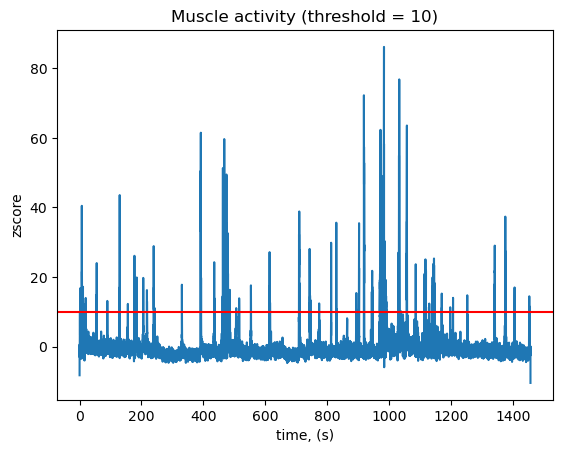

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(data1.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

From this figure we can see that the threshold is above the baseline level. Still, it captures all the picks in high-gamma activity representing muscle artifacts. 

## Include annotations in dataset and inspect

Now mark all the annotations in the data set: 

In [8]:
data1.set_annotations(annotations_blink+annotations_muscle)

/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/2687702282.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data1.set_annotations(annotations_blink+annotations_muscle)


<Raw | sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif, 343 x 1457000 (1457.0 s), ~3.72 GB, data loaded>

To inspect the annotations write

Using matplotlib as 2D backend.


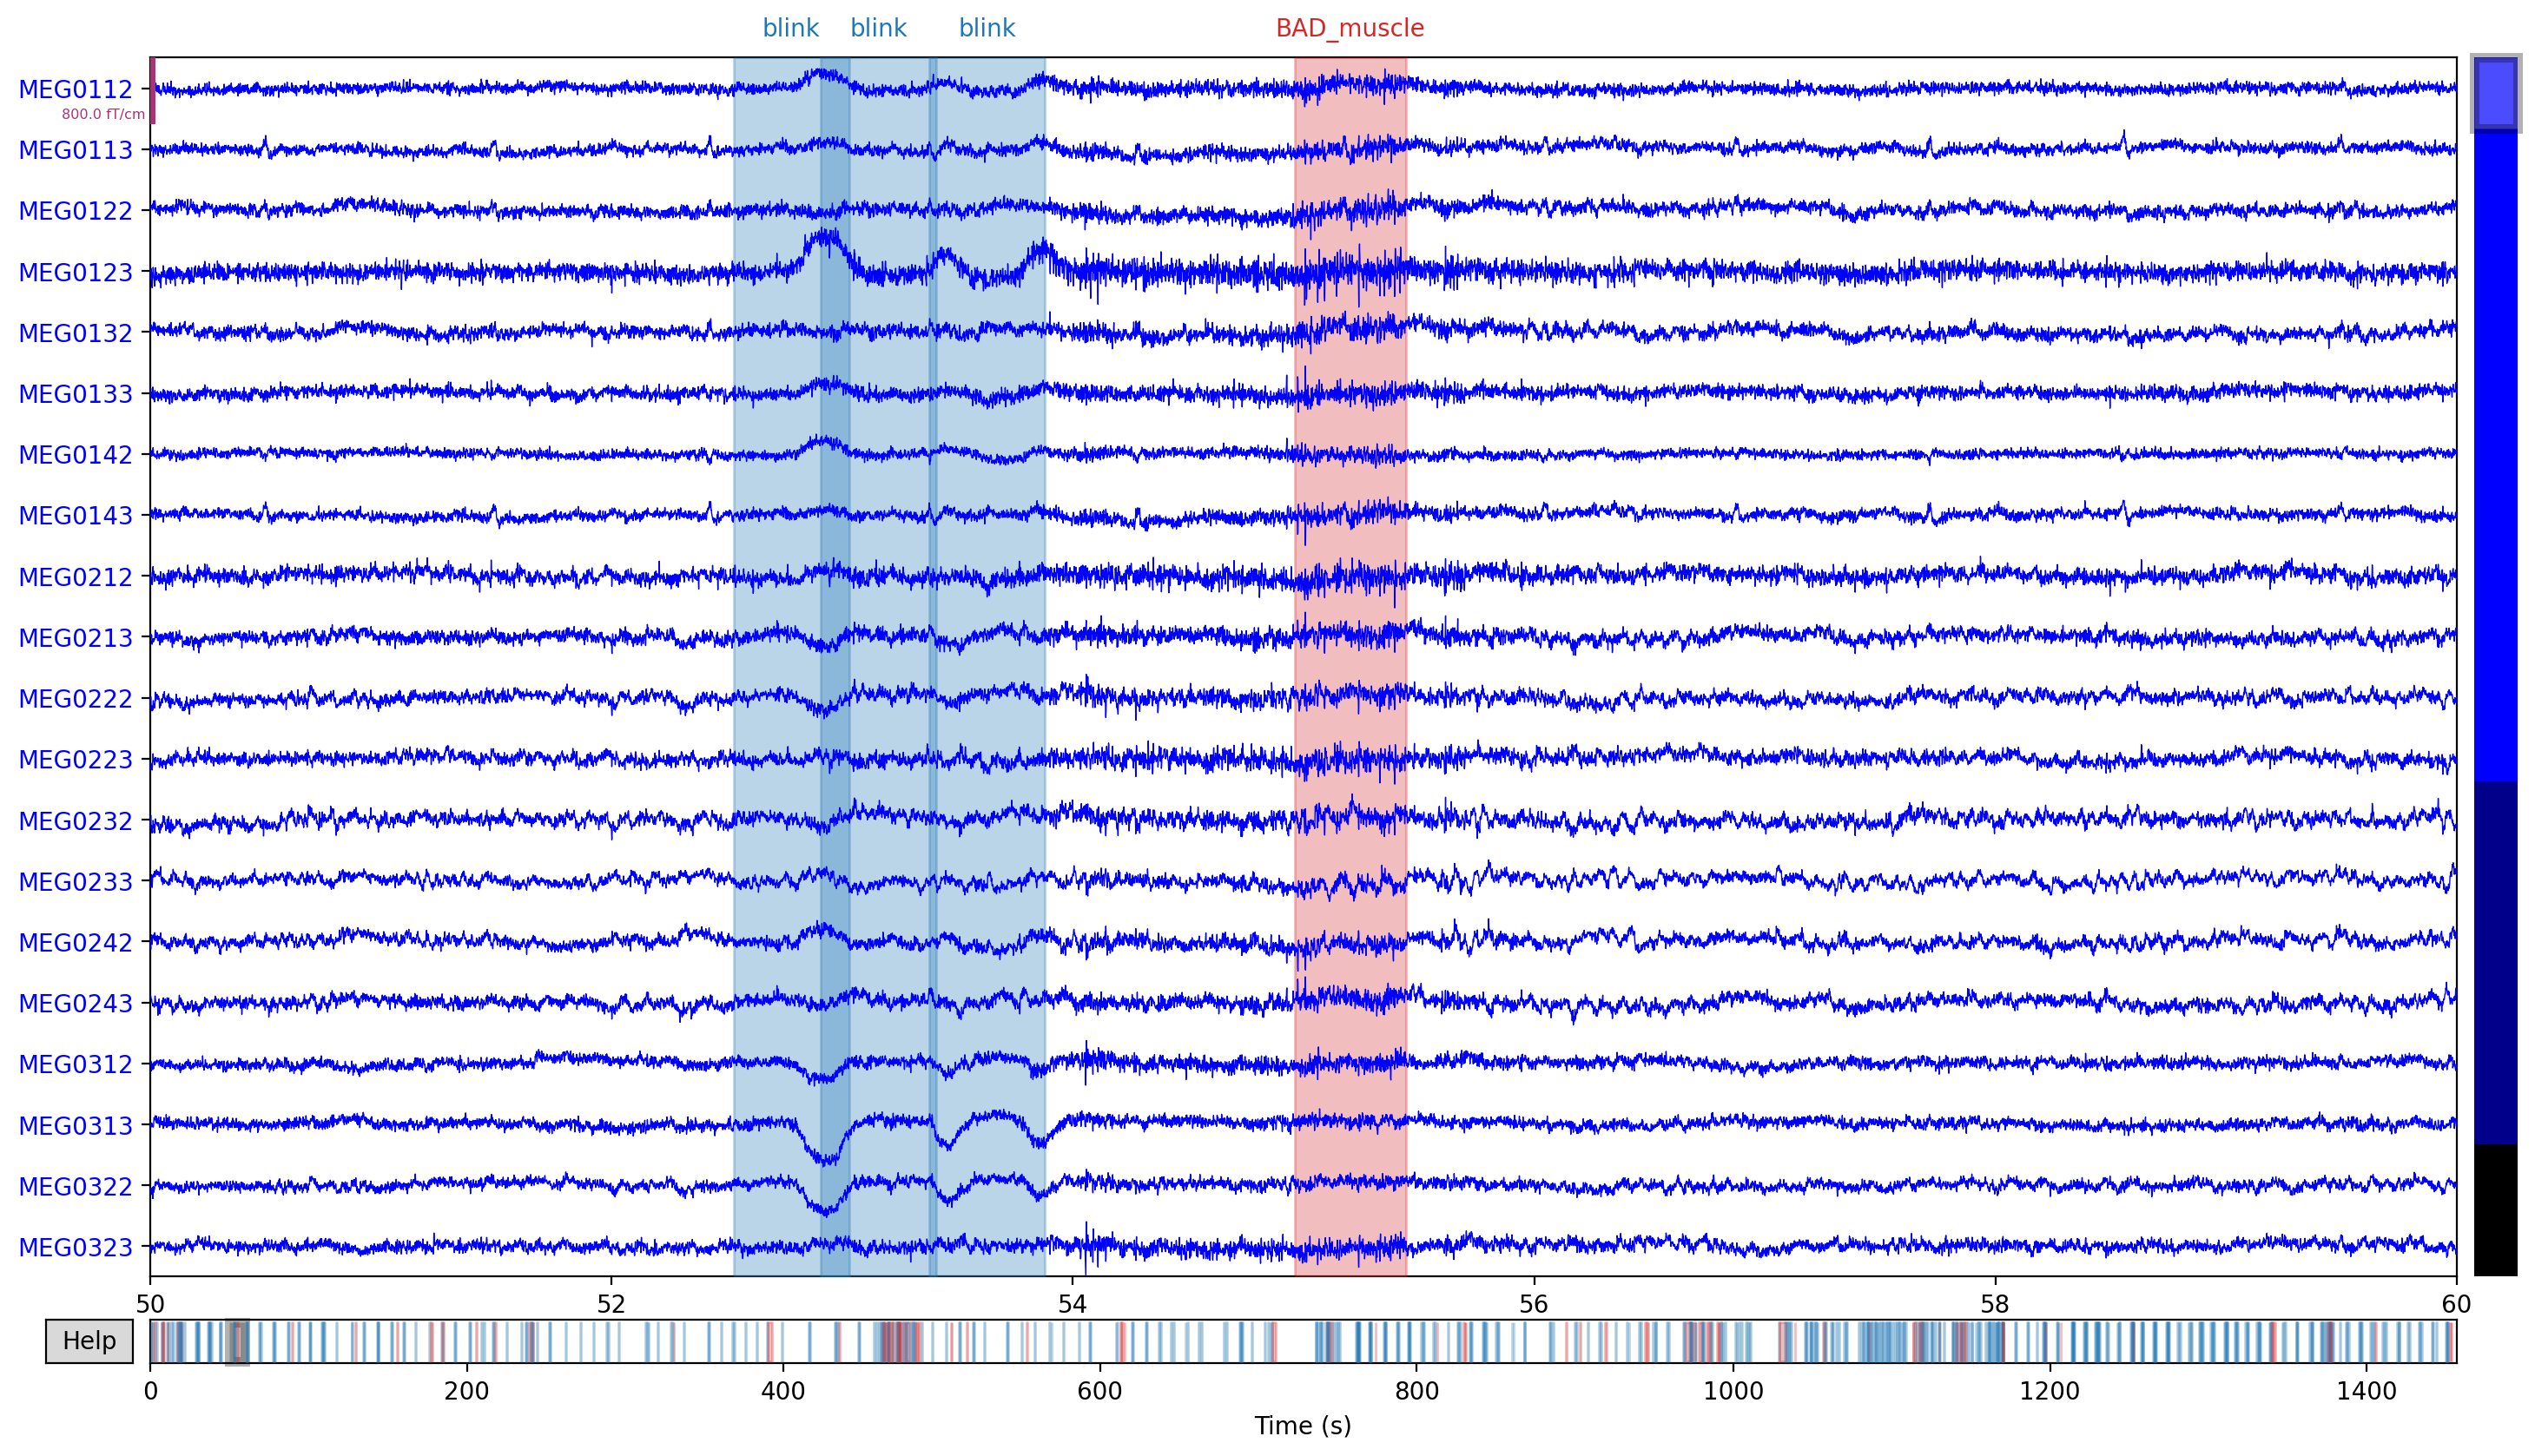

In [9]:
%matplotlib qt
data1.plot(start=50)

To specifically inspect the ocular artifacts display the EOG sensors: 

/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1667905882.py:2: RuntimeWarning: The unit for channel(s) EOG001 has changed from NA to V.
  data1.set_channel_types({'EOG001': 'eog'})
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1667905882.py:3: RuntimeWarning: The unit for channel(s) EOG002 has changed from NA to V.
  data1.set_channel_types({'EOG002': 'eog'})


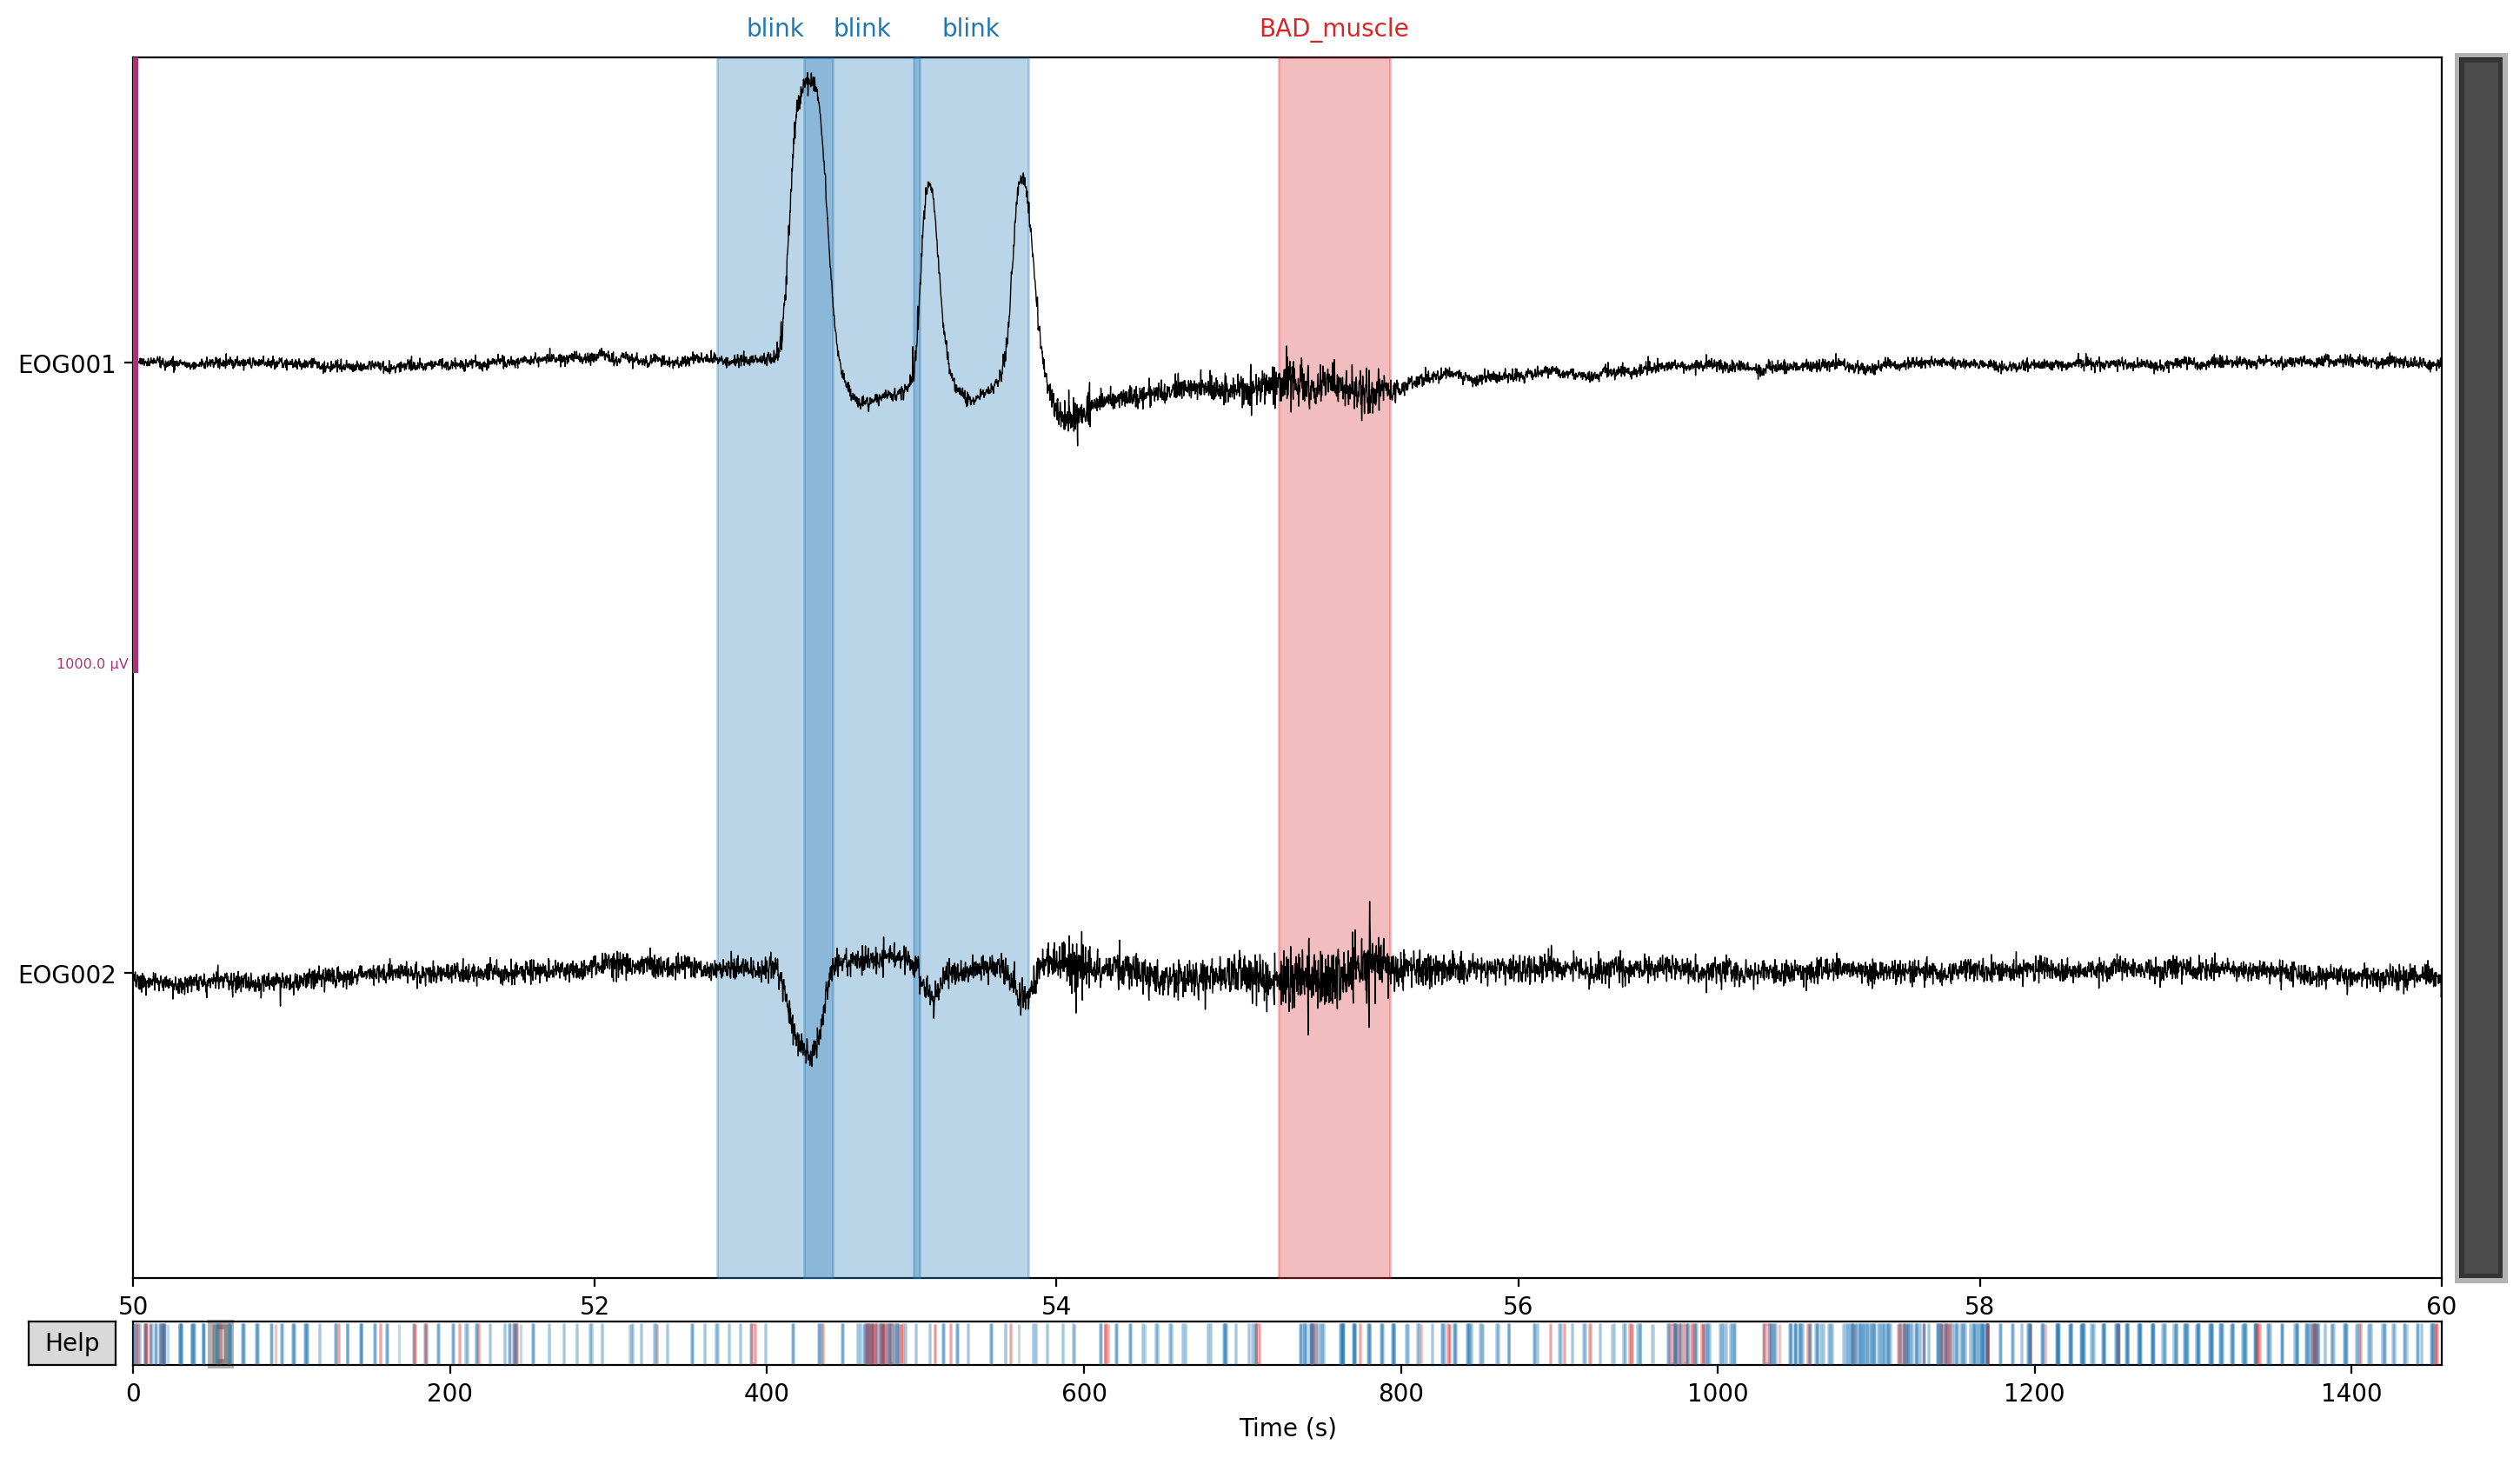

In [10]:
# Set the channel type as 'eog'
data1.set_channel_types({'EOG001': 'eog'})
data1.set_channel_types({'EOG002': 'eog'})

eog_picks = mne.pick_types(data1.info, meg=False, eog=True)

scl = dict(eog=500e-6)
data1.plot(order=eog_picks, scalings=scl, start=50)

The sensor layout of the sensors in the MEGIN system will be of use for answering the questions below (adapted from Hu et al., 2018).


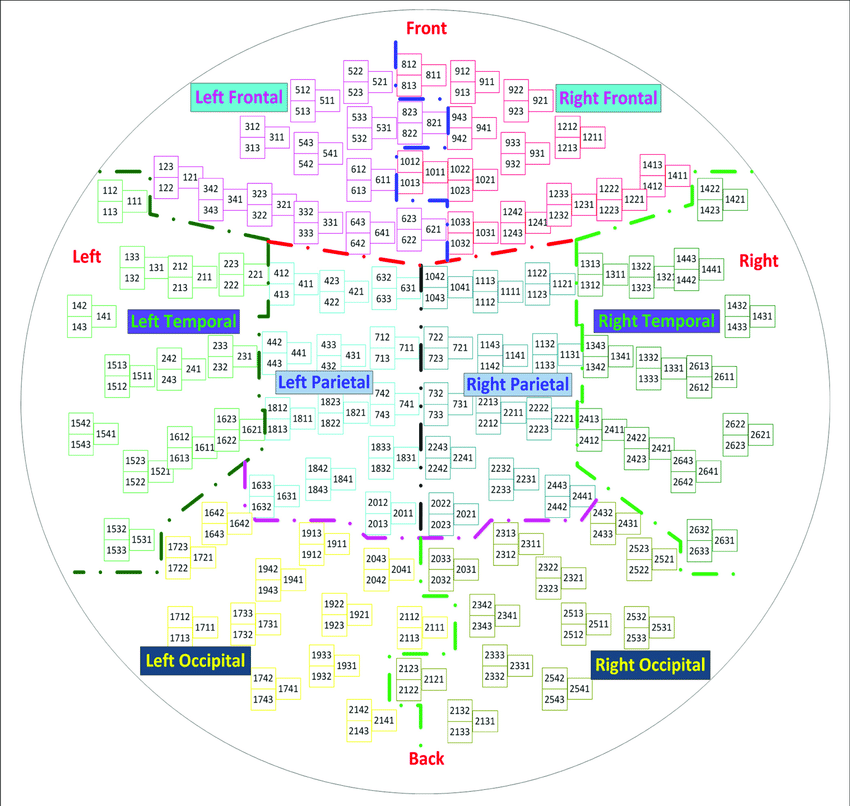


**Question 1:** In which sensors are the muscle artifacts particularly strong? Explain why.

**Question 2:** In which sensors are the ocular artifacts particularly strong? Explain why.

**Question 3:** Is the hEOG or vEOG best for identifying saccades? Explain why. 


## Save the artifact annotations

Save the annotations in a file to be used in the subsequent sections:

In [11]:
data1.annotations.save(ann_fname_1,overwrite=True)

Overwriting existing file.


## Perform artifact annotation on the rest of the dataset 

Now perform the annotation operations on the second FIF-file:

In [12]:
bids_path.update(run='02')
print(bids_path.basename)

data2 = read_raw_bids(bids_path=bids_path, 
                      extra_params={'preload':True},
                      verbose=True) 

# Blinks
eog_events = mne.preprocessing.find_eog_events(data2, ch_name='EOG001') 
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / data2.info['sfreq'] - 0.25
onset -= data2._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
orig_time = data2.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)

# Muscle
threshold_muscle = 10
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

# Annotate the data files
data2.set_annotations(annotations_blink+annotations_muscle)

# Save 
data2.annotations.save(ann_fname_2,overwrite=True)


sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
Opening raw data file /Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades


/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1543377174.py:4: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  data2 = read_raw_bids(bids_path=bids_path,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1543377174.py:4: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  data2 = read_raw_bids(bids_path=bids_path,
/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1543377174.py:4: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/lhunt/scratch/projects/FLUX_pipeline/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*me

Selecting channel EOG001 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.7s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



/var/folders/v8/m87vzy8x1gg_jv4w_shjwn180000gn/T/ipykernel_51933/1543377174.py:25: RuntimeWarning: Omitted 487 annotation(s) that were outside data range.
  data2.set_annotations(annotations_blink+annotations_muscle)


## Pregistration and publication

Preregistration: report the the type of artifacts being annotated as well as the threshold selections. 


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were considered 500 ms long centred around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. " 

## References 

Muthukumaraswamy, S. (2013). High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616

